In [1]:
# execute this cell before you start

import tensorflow as tf
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

print(tf.VERSION)
print(tf.keras.__version__)


1.12.0
2.1.6-tf


#  CA4
## due on 02/04/2019

to submit the assignment, please do the following:

- do `Cell -> All output -> Clear` to clear all your output
- save the notebook (CA3.ipynb)

# The Boston Housing Data

Consider the data in  `keras.datasets.boston_housing`. In this case, there are only about 400 training datasets, where each dataset consists of 13 input values which are characteristic for a given property. The output corresponds to the property price. The meaning of the various columns is explained in https://www.kaggle.com/c/boston-housing.

In contrast to the previous examples, which were categorisation problems, this is now a regression problem. The challenge is to train a network, which is able to predict the price of the property. 

You will again find lots of examples on the internet, and it is okay to use inspiration as long as you provide the source. 

Adhere to the following rules:

a) Train the network on the logarithm of the price, not on the price itself. Explain why this makes sense. 

b) You will find many examples, which use `sci-kit learn` or other packages, which we did not do in the course. Do not use them, and restrict yourself to methods and libraries which we covered

c) Try to find a network, which has the smallest amount of trainable parameters, while still providing good predictions of the price.  Discuss, how small you can go. 

d) Once you have trained the network, explore the correlations which this network predicts:
    - Which inputs have a positive price correlation? 
    - Which inputs have a negative price correlation? 
    - Which inputs have little/no influence on the price?
    
  Investigate this by feeding into the network some artificial data, which you obtain from the testing data by varying one of the input columns.
  
  
Optional challenge (no extra points but extra insight!):

Compare the results with standard regression methods, for example as in ST4060/ST4061 in case you have covered them. 



In [2]:
(train_x, train_y), (test_x, test_y) = keras.datasets.boston_housing.load_data()

# from https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html
var_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
             'DIS', 'RAD', 'TAX', 'PTRATIO', 'BLACK', 'LSTAT', 'MEDV']

Method to print first n entries in the training data

In [3]:
def printFirstN(n, x=train_x, y=train_y):
    print(("{:8}"*len(var_names)).format(*var_names))
    for i in range(10):
        print(
            ("{:<8.4}"*len(x[i])).format(*x[i]),
             "{:<8.3}".format(y[i])
        )

In [4]:
#Explore the data
print('Train X shape', train_x.shape)
print('Train Y shape', train_y.shape)
print('Test X shape', test_x.shape)
print('Train Y shape', test_y.shape)
print()

#inspect a few elements to get an idea of the data
printFirstN(10)

    

Train X shape (404, 13)
Train Y shape (404,)
Test X shape (102, 13)
Train Y shape (102,)

CRIM    ZN      INDUS   CHAS    NOX     RM      AGE     DIS     RAD     TAX     PTRATIO BLACK   LSTAT   MEDV    
1.232   0.0     8.14    0.0     0.538   6.142   91.7    3.977   4.0     307.0   21.0    396.9   18.72    15.2    
0.02177 82.5    2.03    0.0     0.415   7.61    15.7    6.27    2.0     348.0   14.7    395.4   3.11     42.3    
4.898   0.0     18.1    0.0     0.631   4.97    100.0   1.333   24.0    666.0   20.2    375.5   3.26     50.0    
0.03961 0.0     5.19    0.0     0.515   6.037   34.5    5.985   5.0     224.0   20.2    396.9   8.01     21.1    
3.693   0.0     18.1    0.0     0.713   6.376   88.4    2.567   24.0    666.0   20.2    391.4   14.65    17.7    
0.2839  0.0     7.38    0.0     0.493   5.708   74.3    4.721   5.0     287.0   19.6    391.1   11.74    18.5    
9.187   0.0     18.1    0.0     0.7     5.536   100.0   1.58    24.0    666.0   20.2    396.9   23.6     11.3    

It looks like the values of each predictor are very different in scale when compared to each other.
This may lead to difficulties in building a good enough model.
Hence scale them uniformly.

Although scaling the data on a scale of 0 to 1, as in the following commented cell works,
a better mean absolute error is obtained by centering the data on its mean and then scaling it using the 
standard deviation (as shown in https://www.kaggle.com/shanekonaung/boston-housing-price-dataset-with-keras)

In [5]:
# train_x = (train_x - train_x.min(axis=0)) / (train_x.max(axis=0) - train_x.min(axis=0))
# test_x = (test_x - test_x.min(axis=0)) / (test_x.max(axis=0) - test_x.min(axis=0))

In [6]:
# Scaling criteria from https://www.kaggle.com/shanekonaung/boston-housing-price-dataset-with-keras
mean = train_x.mean(axis=0)
train_x = train_x - mean
std = train_x.std(axis=0)
train_x = train_x/std

test_x = test_x-mean
test_x = test_x/std

### a) Train the network on the logarithm of the price, not on the price itself. Explain why this makes sense.

The loss function we'll be using is mean_squared_error. This means that the price values that are too large or too small will have a major influence on the model. Log transformation is a way to reduce this influence.
Hence : 

In [7]:
log_train_y = np.log(train_y)
log_test_y = np.log(test_y)

Inspect the scaled data:

In [8]:
printFirstN(10)

CRIM    ZN      INDUS   CHAS    NOX     RM      AGE     DIS     RAD     TAX     PTRATIO BLACK   LSTAT   MEDV    
1.232   0.0     8.14    0.0     0.538   6.142   91.7    3.977   4.0     307.0   21.0    396.9   18.72    15.2    
0.02177 82.5    2.03    0.0     0.415   7.61    15.7    6.27    2.0     348.0   14.7    395.4   3.11     42.3    
4.898   0.0     18.1    0.0     0.631   4.97    100.0   1.333   24.0    666.0   20.2    375.5   3.26     50.0    
0.03961 0.0     5.19    0.0     0.515   6.037   34.5    5.985   5.0     224.0   20.2    396.9   8.01     21.1    
3.693   0.0     18.1    0.0     0.713   6.376   88.4    2.567   24.0    666.0   20.2    391.4   14.65    17.7    
0.2839  0.0     7.38    0.0     0.493   5.708   74.3    4.721   5.0     287.0   19.6    391.1   11.74    18.5    
9.187   0.0     18.1    0.0     0.7     5.536   100.0   1.58    24.0    666.0   20.2    396.9   23.6     11.3    
4.097   0.0     19.58   0.0     0.871   5.468   100.0   1.412   5.0     403.0   14.7    3

Method to build the model:

In [9]:
def buildModel(numNeurons):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(numNeurons, activation=tf.nn.relu, input_shape=(train_x.shape[1],)))
    model.add(keras.layers.Dense(numNeurons, activation=tf.nn.relu))
    model.add(keras.layers.Dense(1))
    
    return model;

Now fit and inspect the model:

In [10]:
%%time
model = buildModel(512)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
fit_result = model.fit(train_x, train_y, epochs=100, batch_size=1, validation_data=(test_x, test_y))

Train on 404 samples, validate on 102 samples
Epoch 1/100
404/404 [==============================] - 1s 3ms/step - loss: 61.3797 - mean_absolute_error: 4.8720 - val_loss: 28.7380 - val_mean_absolute_error: 3.9255
Epoch 2/100
404/404 [==============================] - 1s 4ms/step - loss: 17.0476 - mean_absolute_error: 2.9870 - val_loss: 25.7714 - val_mean_absolute_error: 3.4253
Epoch 3/100
404/404 [==============================] - 1s 3ms/step - loss: 13.9369 - mean_absolute_error: 2.8920 - val_loss: 26.7388 - val_mean_absolute_error: 3.7287
Epoch 4/100
404/404 [==============================] - 1s 2ms/step - loss: 14.2786 - mean_absolute_error: 2.7738 - val_loss: 19.8741 - val_mean_absolute_error: 3.0214
Epoch 5/100
404/404 [==============================] - 1s 3ms/step - loss: 12.4985 - mean_absolute_error: 2.6524 - val_loss: 23.0081 - val_mean_absolute_error: 3.4942
Epoch 6/100
404/404 [==============================] - 1s 3ms/step - loss: 12.7823 - mean_absolute_error: 2.6684 - val_

Epoch 50/100
404/404 [==============================] - 1s 3ms/step - loss: 6.6989 - mean_absolute_error: 1.7843 - val_loss: 14.6550 - val_mean_absolute_error: 2.6250
Epoch 51/100
404/404 [==============================] - 1s 3ms/step - loss: 4.2732 - mean_absolute_error: 1.5907 - val_loss: 12.7335 - val_mean_absolute_error: 2.4992
Epoch 52/100
404/404 [==============================] - 1s 3ms/step - loss: 4.2760 - mean_absolute_error: 1.5891 - val_loss: 11.8444 - val_mean_absolute_error: 2.4465
Epoch 53/100
404/404 [==============================] - 1s 3ms/step - loss: 5.0299 - mean_absolute_error: 1.6399 - val_loss: 15.5296 - val_mean_absolute_error: 2.8776
Epoch 54/100
404/404 [==============================] - 1s 3ms/step - loss: 3.8541 - mean_absolute_error: 1.4658 - val_loss: 12.6393 - val_mean_absolute_error: 2.4075
Epoch 55/100
404/404 [==============================] - 1s 3ms/step - loss: 3.5889 - mean_absolute_error: 1.4299 - val_loss: 12.4756 - val_mean_absolute_error: 2.394

404/404 [==============================] - 1s 3ms/step - loss: 2.0211 - mean_absolute_error: 1.0576 - val_loss: 12.2802 - val_mean_absolute_error: 2.3611
Epoch 100/100
404/404 [==============================] - 1s 2ms/step - loss: 2.6288 - mean_absolute_error: 1.2043 - val_loss: 12.2272 - val_mean_absolute_error: 2.3871
CPU times: user 3min 40s, sys: 31.2 s, total: 4min 11s
Wall time: 1min 47s


In [13]:
history = fit_result.history

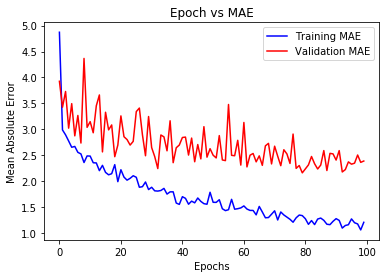

In [14]:
plt.plot(fit_result.epoch, history['mean_absolute_error'], 'b', label='Training MAE')
plt.plot(fit_result.epoch, history['val_mean_absolute_error'], 'r', label='Validation MAE')
plt.title('Epoch vs MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

The plot says that although the training MAE goes down almost monotonously, the test MAE remains more or less the same after about 60 epochs. This hints that the model has been overfitted. 
This is confirmed by the Epochs vs Loss plot below:

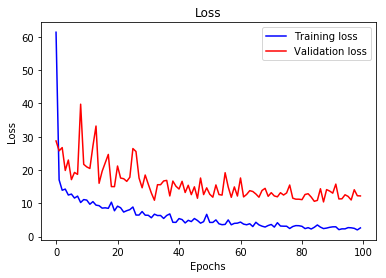

In [15]:
plt.plot(fit_result.epoch, history['loss'], 'b', label='Training loss')
plt.plot(fit_result.epoch, history['val_loss'], 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### c)  Try to find a network, which has the smallest amount of trainable parameters, while still providing good predictions of the price. Discuss, how small you can go.

Loop through the number of neurons to find the value providing minimum mean absolute error

In [ ]:
%%time

min_neurons = 8
num_neurons = 512
mae_dict = {}
models_dict = {}
while(num_neurons >= min_neurons):
    
    print("Fitting model for neurons = ", num_neurons)
    model_test = buildModel(num_neurons)
    model_test.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    model_test.fit(train_x, train_y, epochs=100, batch_size=1)
    
    print("Summary for neurons = ", num_neurons)
    model_test.summary()
    
    val_mse, val_mae = model_test.evaluate(test_x, test_y)
    mae_dict[num_neurons] = val_mae
    models_dict[num_neurons] = model_test
    
    num_neurons /= 2

print(mae_dict)

Find the number of neurons which gives minimum mean absolute error:

In [ ]:
neuronWithMinMAE = min(mae_dict, key=mae_dict.get)

In [ ]:
print("It appears that {} is enough for a network to have sufficient accuracy", neuronWithMinMAE)

### d) Once you have trained the network, explore the correlations which this network predicts:

Find the model with minimum number of trainable parameters

In [ ]:
model = models_dict[neuronWithMinMAE]

Replace each column in the data with its max value and make a new set of predictions on that.
Comparing this with the original predictions can give an idea on the correlation of each variable
with the price

In [ ]:
original_predictions = model.predict(test_x)
new_predictions = [];

# iterate over the columns
for j in range(len(var_names) - 1):
    # Make a copy of the original so that its column can be modified
    test_x_copy = np.copy(test_x)
    
    # set all values in the current column to the max value
    for i in range(len(test_x)):
        test_x_copy[i][j] = test_x.max(axis=0)[j];  
        
    # Now make the prediction again with the modified data
    new_prediction = model.predict(test_x_copy)
    new_predictions.append(new_prediction)
    


Now plot the Original Prediction and Modified prediction for each variable

In [ ]:
num_predictions = len(original_predictions)

plt.figure(figsize=(40,40))
for i in range(13):
    plt.subplot(5,3, i + 1)
    x = list(range(num_predictions))
    plt.plot(x, original_predictions, label='Original Predictions')
    plt.plot(x, new_predictions[i], label='Modified Predictions')
    plt.title(var_names[i])
    plt.legend()

From the plots, conclusions on the correlations of each of the predictors on the price can be made as follows:

* Positive Price Correlation : RM, RAD
* Negative Price Correlation : CRIM
* Little/No Price Correlation : All others



In [ ]:
%reset